# SPGR

In [2]:
import version_control
%gui qt

In [3]:
from spgr import lg
from logging import INFO
lg.setLevel(INFO)

/home/gpiantoni/miniconda3/lib/python3.4/site-packages/IPython/external/qt_loaders.py:118: ResourceWarning: unclosed file <_io.BufferedReader name='/home/gpiantoni/miniconda3/lib/python3.4/site-packages/PyQt4/QtCore.so'>
  imp.find_module('QtCore', mod.__path__)
/home/gpiantoni/miniconda3/lib/python3.4/site-packages/IPython/external/qt_loaders.py:119: ResourceWarning: unclosed file <_io.BufferedReader name='/home/gpiantoni/miniconda3/lib/python3.4/site-packages/PyQt4/QtGui.so'>
  imp.find_module('QtGui', mod.__path__)
/home/gpiantoni/miniconda3/lib/python3.4/site-packages/IPython/external/qt_loaders.py:120: ResourceWarning: unclosed file <_io.BufferedReader name='/home/gpiantoni/miniconda3/lib/python3.4/site-packages/PyQt4/QtSvg.so'>
  imp.find_module('QtSvg', mod.__path__)


## Plot Coverage

In [4]:
from os import listdir, makedirs
from os.path import join

In [5]:
from numpy import NaN, atleast_2d, sum, histogram, log, nanmin, nanmax, median, nanmean, where, isnan, nansum, empty, ones

In [6]:
from phypno import Data
from phypno.attr import Freesurfer
from phypno.source import Linear, Morph
from phypno.viz.plot_3d import Viz3

In [7]:
from spgr.read_data import DATA_DIR, REC_DIR, FS_PATH, get_chan_used_in_analysis

In [8]:
all_subj = sorted(listdir(DATA_DIR))

hemi_subj = {'EM09': 'rh', 
             'MG17': 'rh',
             'MG33': 'lh',
             'MG37': 'lh',
             'MG61': 'lh',
             'MG63': 'rh',
             }

options = {'reref': 'avg',
           'resample_freq': 256,
           'hp_filter': 0.5,
           'lp_filter': 50,
           }

We projected the activity of each electrode to the cortex using a Gaussian window of standard deviation of 10mm.
Electrodes farther than 20 mm did not have any influence.

In [9]:
STD = 10
THRESHOLD = 20

Activity was morphed onto the average brain that ships with FreeSurfer.

For the six patients, 3 had coverage on the right and 3 had coverage on the left hemisphere.
The majority of the coverage was over the low frontal / frontal temporal regions (Table +[spgr_region_names]).

In [10]:
all_elec = []

for subj in all_subj:

    chan = get_chan_used_in_analysis(subj, 'sleep', ('grid', ), **options)[1]
    if hemi_subj[subj] == 'lh':
        for one_chan in chan.chan:
            one_chan.xyz *= (-1, 1, 1)

    data = Data(ones(chan.n_chan), chan=chan.return_label())

    fs = Freesurfer(join(REC_DIR, subj, FS_PATH))
    surf = fs.read_surf('rh')
    l = Linear(surf, chan, std=STD, threshold=THRESHOLD)
    m = Morph(surf)
    
    all_elec.append(m(l(data)))

INFO:/home/gpiantoni/projects/spgr/scripts/spgr/read_data.py:EM09 analysis chan 69, with location 69


Morphing data...
Triangle file: b'created by greve on Thu Jun  8 19:17:51 2006' nvert = 163842 ntri = 327680
Triangle file: b'created by greve on Thu Jun  8 19:17:51 2006' nvert = 163842 ntri = 327680
Triangle file: b'created by gio on Fri Apr  4 19:00:54 2014' nvert = 171672 ntri = 343340
Triangle file: b'created by gio on Fri Apr  4 21:09:46 2014' nvert = 158992 ntri = 317980
    Left-hemisphere map read.
    Right-hemisphere map read.
    1 smooth iterations done.
[done]


INFO:/home/gpiantoni/projects/spgr/scripts/spgr/read_data.py:MG17 analysis chan 93, with location 93


Morphing data...
Triangle file: b'created by greve on Thu Jun  8 19:17:51 2006' nvert = 163842 ntri = 327680
Triangle file: b'created by greve on Thu Jun  8 19:17:51 2006' nvert = 163842 ntri = 327680
Triangle file: b'created by gio on Wed Dec  4 10:58:01 2013' nvert = 118351 ntri = 236698
Triangle file: b'created by gio on Wed Dec  4 13:03:36 2013' nvert = 107919 ntri = 215834
    Left-hemisphere map read.
    Right-hemisphere map read.
    1 smooth iterations done.
[done]


INFO:/home/gpiantoni/projects/spgr/scripts/spgr/read_data.py:MG33 analysis chan 64, with location 64


Morphing data...
Triangle file: b'created by greve on Thu Jun  8 19:17:51 2006' nvert = 163842 ntri = 327680
Triangle file: b'created by greve on Thu Jun  8 19:17:51 2006' nvert = 163842 ntri = 327680
Triangle file: b'created by gio on Thu Dec  5 10:36:24 2013' nvert = 125574 ntri = 251144
Triangle file: b'created by gio on Thu Dec  5 13:17:36 2013' nvert = 138978 ntri = 277952
    Left-hemisphere map read.
    Right-hemisphere map read.
    1 smooth iterations done.
[done]


INFO:/home/gpiantoni/projects/spgr/scripts/spgr/read_data.py:MG37 analysis chan 78, with location 78


Morphing data...
Triangle file: b'created by greve on Thu Jun  8 19:17:51 2006' nvert = 163842 ntri = 327680
Triangle file: b'created by greve on Thu Jun  8 19:17:51 2006' nvert = 163842 ntri = 327680
Triangle file: b'created by gio on Thu Mar 13 17:44:21 2014' nvert = 151279 ntri = 302554
Triangle file: b'created by gio on Thu Mar 13 18:54:03 2014' nvert = 154198 ntri = 308392
    Left-hemisphere map read.
    Right-hemisphere map read.
    1 smooth iterations done.
[done]


INFO:/home/gpiantoni/projects/spgr/scripts/spgr/read_data.py:MG61 analysis chan 93, with location 93


Morphing data...
Triangle file: b'created by greve on Thu Jun  8 19:17:51 2006' nvert = 163842 ntri = 327680
Triangle file: b'created by greve on Thu Jun  8 19:17:51 2006' nvert = 163842 ntri = 327680
Triangle file: b'created by gio on Wed Dec  4 10:53:47 2013' nvert = 104599 ntri = 209194
Triangle file: b'created by gio on Wed Dec  4 13:15:03 2013' nvert = 135906 ntri = 271808
    Left-hemisphere map read.
    Right-hemisphere map read.
    1 smooth iterations done.
[done]


INFO:/home/gpiantoni/projects/spgr/scripts/spgr/read_data.py:MG63 analysis chan 93, with location 93


Morphing data...
Triangle file: b'created by greve on Thu Jun  8 19:17:51 2006' nvert = 163842 ntri = 327680
Triangle file: b'created by greve on Thu Jun  8 19:17:51 2006' nvert = 163842 ntri = 327680
Triangle file: b'created by gio on Fri Dec  6 17:49:39 2013' nvert = 136748 ntri = 273492
Triangle file: b'created by gio on Fri Dec  6 18:59:10 2013' nvert = 134194 ntri = 268384
    Left-hemisphere map read.
    Right-hemisphere map read.
    1 smooth iterations done.
[done]


In [14]:
%load_ext autoreload
%autoreload 2

In [11]:
from copy import deepcopy
from numpy import nansum, NaN, asarray

avg_elec = deepcopy(all_elec[0])
avg_elec.data[0] = nansum(asarray([x.data[0] for x in all_elec]), axis=0)

In [20]:
fs_avg = Freesurfer('/home/gpiantoni/projects/spgr/subjects/EM09/mri/proc/fsaverage')
surf_avg = fs_avg.read_surf('rh', surf_type='pial')
v = Viz3()
v.add_surf(surf_avg, values=avg_elec(trial=0)[163842:], limits_c=(0, 6), colormap='jet')

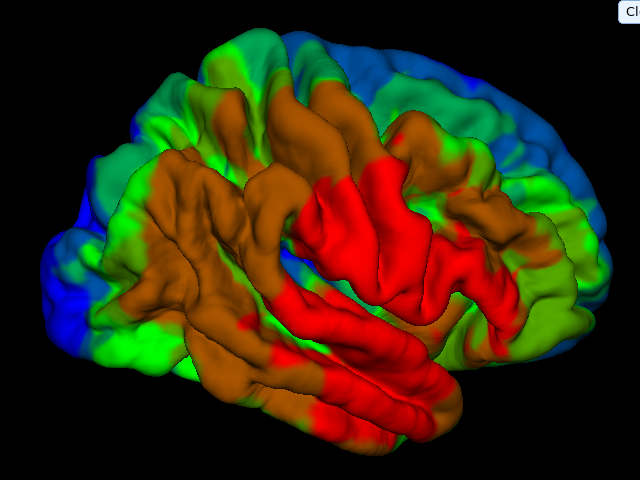

In [21]:
v